# Modeling Census Data to Predict STEM Employment

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary, gainsChart
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import pprint
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB

In [20]:
df=pd.read_csv('./datasets/transformed/main_df.csv')
df.head(3)

,SEX,AGE,stemType,stemBinary,State,under_represented,domestic_born,EDU_verbose,is_STEM_degree,STEM_Degree_Area
0,0,53,-1,0,Wisconsin,0,1,High School,0,None
1,0,56,-1,0,New York,0,1,High School,0,None
2,1,35,-1,0,Pennsylvania,0,0,Bachelor,0,None


In [21]:
#selecting the feautures for modeling
features = [
    'SEX'
    #,'State'
    ,'AGE'
    ,'domestic_born'
    ,'EDU_verbose'
    ,'is_STEM_degree'
    ,'under_represented'
    ,'stemType'
    ,'stemBinary'
    ,'STEM_Degree_Area'
]
df_model=df[features]
del df

In [22]:
df_model['stemType'].value_counts()

-1                                                                                 188145
Research, Development, Design, and Practitioners                                     4031
Other                                                                                1049
Managerial                                                                            768
Research, Development, Design, and Practitioners; Technologists and Technicians       612
Technologists and Technicians                                                         355
Sales                                                                                  39
Name: stemType, dtype: int64

For our target variable, we can discard `stemType` and instead opt for `stemBinary`, which is a binarized version of this feature that was created during EDA. For consistency, a simple drop operation will do:

In [23]:
#binarize STEM
df_model = df_model.drop(columns=['stemType'])
df_model = df_model.rename(columns={'stemBinary':'stemType'})
df_model.head(3)

,SEX,AGE,domestic_born,EDU_verbose,is_STEM_degree,under_represented,stemType,STEM_Degree_Area
0,0,53,1,High School,0,0,0,None
1,0,56,1,High School,0,0,0,None
2,1,35,0,Bachelor,0,0,0,None


In order to deploy our ML model online using streamlit, we need to save a version of our full dataset that enables the user to define the value for each feature before we do encoding for categorical variables.

In [24]:
df_model.to_csv('streamlit/data.csv',index=None)

### Class Imbalance
Recognizing that the majority of individuals are not in STEM, we first evaluate how heavy or class imabalance is. We intend to fix this issue by over-sampling individuals who found placement in a STEM role using SMOTE. 

Text(0.5, 0, 'stemType')

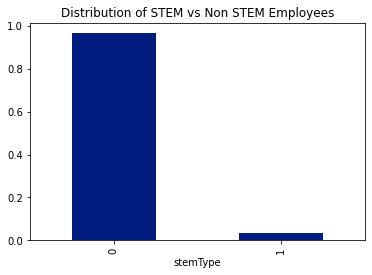

In [25]:
df_model['stemType'].value_counts(normalize=True).plot(
    kind='bar'
    ,title='Distribution of STEM vs Non STEM Employees'
)
plt.xlabel('stemType')

We can acquire the indices of our categorical variables by using `the get_loc` function.
finally, we call on SMOTENC to treat our education and degree type as categorical variables and oversample the minority class.

In [26]:
X = df_model.drop(columns='stemType')
y = df_model['stemType']

edu_verb = X.columns.get_loc('EDU_verbose')
stem_deg = X.columns.get_loc('STEM_Degree_Area')

smote_nc = SMOTENC(
    categorical_features = [edu_verb,stem_deg]
    ,random_state=42
    ,sampling_strategy='minority'
)

X_res,y_res = smote_nc.fit_resample(X,y)

In [27]:
#recombine X and Y into one dataframe, shed y_res from memory to save space
X_res['stemType'] = y_res
del y_res

Having oversampled our minority class, we check for distribution one more time to confirm that SMOTE worked:

Text(0.5, 0, 'stemType')

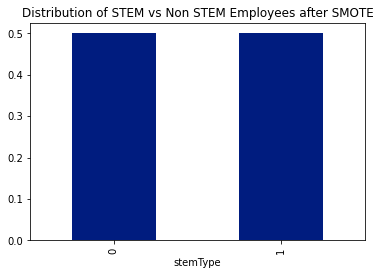

In [28]:
X_res['stemType'].value_counts(normalize=True).plot(
    kind='bar'
    ,title='Distribution of STEM vs Non STEM Employees after SMOTE'
)
plt.xlabel('stemType')

### Creating Dummy Variables for Education and Degree Area

Given that there's several different levels of education, we would benefit from using dummy variables in our modeling for them:

In [29]:
a = pd.get_dummies(X_res['STEM_Degree_Area'],prefix='STEM_Degree_Area')
b = pd.get_dummies(X_res['EDU_verbose'],prefix='EDU_verbose')#get dummy variables for Education

frames = [
    X_res
    , a
    , b] # append them as a list
df_model = pd.concat(frames, axis = 1)
df_model=df_model.drop(columns = [
    'EDU_verbose',
    'STEM_Degree_Area'
]) 
df_model.head()

,SEX,AGE,domestic_born,is_STEM_degree,under_represented,stemType,STEM_Degree_Area_Agriculture,STEM_Degree_Area_Biology and Life Sciences,STEM_Degree_Area_Business,STEM_Degree_Area_Computer and Information Sciences,...,STEM_Degree_Area_Military Technologies,STEM_Degree_Area_None,"STEM_Degree_Area_Nuclear, Industrial Radiology, and Biological Technologies",STEM_Degree_Area_Physical Sciences,EDU_verbose_Associate,EDU_verbose_Bachelor,EDU_verbose_High School,EDU_verbose_Master,EDU_verbose_None/Below HS,EDU_verbose_PhD
0,0,53,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,56,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,1,35,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,30,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,47,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


We should also normalize our Age variable by subtracting the mean and dividing by the standard deviation.

In [30]:
print(f"Age Std. Dev:{df_model['AGE'].std()}")
print(f"Mean Age:{df_model['AGE'].mean()}")

Age Std. Dev:16.949458365700444
Mean Age:47.46299928246831


In [31]:
df_model['AGE'] = (df_model['AGE']-df_model['AGE'].mean())/df_model['AGE'].std()
df_model['AGE'].head(3)

0    0.326677
1    0.503674
2   -0.735304
Name: AGE, dtype: float64

Finally, we split our dataset into a training, testing, and validation set.

In [32]:
X = df_model.drop(columns=['stemType'])
y = df_model['stemType']
train_X_res, rem_X, train_y_res, rem_y = train_test_split(X, y, train_size=0.6, random_state=42, stratify = y)
valid_X, test_X, valid_y, test_y = train_test_split(rem_X, rem_y, train_size=0.5, random_state=42, stratify = rem_y) 

In [33]:
print('Training Set:\n', train_y_res.value_counts(), '\n', train_y_res.value_counts(normalize = True))
print('\nValidation Set:\n', valid_y.value_counts(), '\n', valid_y.value_counts(normalize = True))
print('\nTest Set:\n', test_y.value_counts(), '\n', test_y.value_counts(normalize = True))

Training Set:
 0    112887
1    112887
Name: stemType, dtype: int64 
 0    0.5
1    0.5
Name: stemType, dtype: float64

Validation Set:
 0    37629
1    37629
Name: stemType, dtype: int64 
 0    0.5
1    0.5
Name: stemType, dtype: float64

Test Set:
 0    37629
1    37629
Name: stemType, dtype: int64 
 0    0.5
1    0.5
Name: stemType, dtype: float64


We can also save our SMOTE data to .csv to avoid having to re-run this data during development work for future replications, which is handled in the **except** statement above.

### Helper Function: Confusion Matrix

In [34]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y_res, model.predict(train_X_res))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

### Helper Function: Evaluation Metrics

In [35]:
def evalMetrics(model,mod_predict,verbose=True,test_features=test_X):
    # precision tp / (tp + fp)
    precision = precision_score(test_y, mod_predict)
    # recall: tp / (tp + fn)
    recall = recall_score(test_y, mod_predict)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_y, mod_predict)
    
    # ROC AUC
    mp = model.predict_proba(test_features)
    mp = mp[:, 1]
    auc = roc_auc_score(test_y, mp)
    
    if verbose:
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        print('ROC AUC: %f' % auc)
        
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc":auc
    }

### Helper Function: Performance Plotting

In [36]:
def roc_vs(roc_scores,params,param_name):
    # plot
    plt.plot(params,roc_scores)
    max_roc = max(roc_scores)
    max_index = roc_scores.index(max_roc)
    
    try:
        max_param = round(params[max_index],4)
    except:
        max_param = params[max_index]
        
    max_roc = round(max_roc,4)
    plt.ylabel('roc-auc')
    plt.xlabel(param_name)
    plt.title(f'roc-auc score vs {param_name}, max roc:{max_roc}, parameter: {max_param}\n\n')
    plt.show()

### Naive Bayes

In [37]:
gnb = GaussianNB()
gnb.fit(train_X_res, train_y_res)
confusionMatrices(gnb,'Naive Bayes')

Naive Bayes - training results
Confusion Matrix (Accuracy 0.7431)

       Prediction
Actual     0     1
     0 88998 23889
     1 34122 78765
Naive Bayes - validation results
Confusion Matrix (Accuracy 0.7431)

       Prediction
Actual     0     1
     0 29628  8001
     1 11336 26293


#### Evaluation and Confusion Matrix:

In [49]:
gnb_pred = gnb.predict(test_X)
evalMetrics(gnb,gnb_pred,False)

{'precision': 0.7683378539971418,
 'recall': 0.7000983284169124,
 'f1': 0.732632515712776,
 'roc_auc': 0.8382886897525744}

### Logistic Regression - Initial Overview and Tuning

#### Optimizing Inverse Regularization (C)

In [64]:
C_param_range = [0.001,0.01,0.1,1,10,100]
roc_scores = []
for c in C_param_range:

    logit_reg = LogisticRegression(
        penalty="elasticnet"
        , C=c
        , solver='saga'
        , random_state = 1
        , l1_ratio = 0.375
    )
    logit_reg.fit(train_X_res, train_y_res)
    #confusionMatrices(logit_reg, 'Logistic regression')
    logit_pred = logit_reg.predict(test_X)
    roc_scores.append(evalMetrics(logit_reg,logit_pred,False)['roc_auc'])

Although we get optimal performance at C=100, we can use c=0.1 since they offer the same performance.

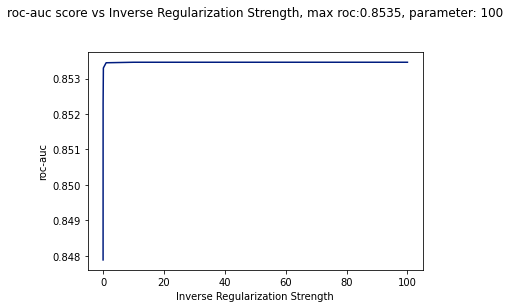

In [65]:
roc_vs(roc_scores,C_param_range,'Inverse Regularization Strength')

#### Optimizing L1-Ratio

In [66]:
l1_ratio = [0.2,0.25,0.3,0.325]
roc_scores = []
for l in l1_ratio:

    logit_reg = LogisticRegression(
        penalty="elasticnet"
        , C=0.1
        , solver='saga'
        , random_state = 1
        , l1_ratio = l
    )
    logit_reg.fit(train_X_res, train_y_res)
    #confusionMatrices(logit_reg, 'Logistic regression')
    logit_pred = logit_reg.predict(test_X)
    roc_scores.append(evalMetrics(logit_reg,logit_pred,False)['roc_auc'])

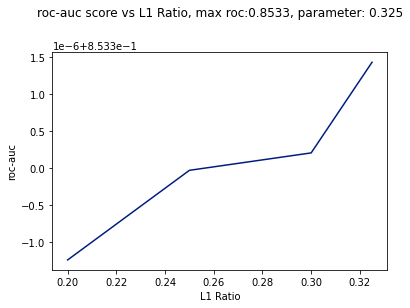

In [67]:
roc_vs(roc_scores,l1_ratio,'L1 Ratio')

#### Deep Search

In [33]:
parameters = {
                'solver': ['lbfgs', 'liblinear', 'saga'],
                'penalty':['elasticnet', 'l1', 'l2'],
                'C':[0.075,0.1,0.125],
                'l1_ratio': [0.1,0.2,0.3,0.4,0.5],
                'random_state': [1]
             }

grid_search = GridSearchCV(
    estimator = LogisticRegression(random_state=1),  
    param_grid = parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1)


grid_search.fit(train_X_res, train_y_res)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.075, 0.1, 0.125], 'l1_ratio': [0.3],
                         'penalty': ['elasticnet', 'l1', 'l2'],
                         'random_state': [1],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [34]:
print(grid_search.best_estimator_)
evalMetrics(grid_search,grid_search.predict(test_X),False)

LogisticRegression(C=0.125, l1_ratio=0.3, random_state=1, solver='saga')


{'precision': 0.8033879814539835,
 'recall': 0.7045363948018816,
 'f1': 0.750722093220819,
 'roc_auc': 0.8533234170913121}

### Random Forest - GridSearch

To optimize random forest performance, we want to cycle through the number of estimators, the maximum tree depth, the log-loss, the cost function, and more:

In [ ]:
rf = RandomForestClassifier(random_state = 1,verbose = 2)

# Number of trees in random forest
n_estimators = [400,450,500,550,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint.pprint(random_grid)

In [ ]:
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf
    , param_distributions = random_grid
    , n_iter = 100
    , cv = 3
    , verbose=2
    , random_state=1
    , n_jobs = -1
    , scoring = 'roc_auc'
)
# Fit the random search model
rf_random.fit(train_X_res, train_y_res)

We can see which parameters perform the best for our random forest:

Continue by reviewing the array of ROC scores we got from our models:

In [ ]:
RandomForest_pred = rf_random.predict(test_X)

In [ ]:
evalMetrics(rf_random,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

We can also compare this with our original model:

In [ ]:
#current best roc ~ 83.7%
RandomForest = RandomForestClassifier(
    n_estimators=500 #current best = 500
    , random_state=1
    , max_depth = 6
)
RandomForest.fit(train_X_res, train_y_res)
RandomForest_pred = RandomForest.predict(test_X)
evalMetrics(RandomForest,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

it appears that despite our eforts to conduct some sort of gridsearch for our random forest model, we're unable to beat the roc of 83.7% using conventional means, and will have to approach this more carefully by tuning each metric alone until we get better insights.

#### 1. Number of Estimators

In [86]:
estimators = [240,250,260,270]
roc_scores = []

for e in estimators:
    RandomForest = RandomForestClassifier(
        n_estimators= e #current best = 500
        , random_state=1
        , max_depth = 6
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 1b. Visualization

we can conclude that around 260 estimators is an optimal number for our random forest clasifier.

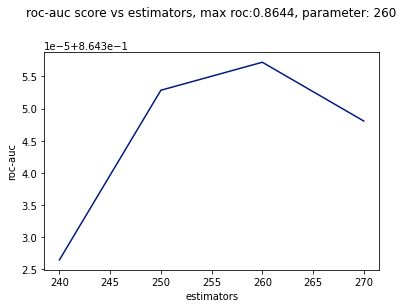

In [87]:
roc_vs(roc_scores,estimators,"estimators")

#### 2. max depth

In [98]:
depths = list(range(15,25))
roc_scores = []

for d in depths:
    RandomForest = RandomForestClassifier(
        n_estimators= 260 #current best = 500
        , random_state=1
        , max_depth = d
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 2b. Visualization

a max depth of 22 seems to be an optimal parameter at this stage.

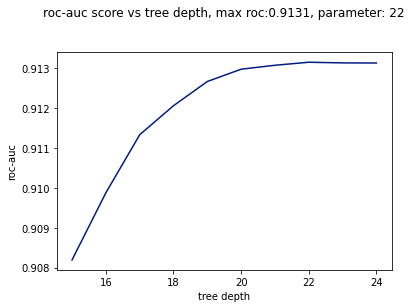

In [99]:
roc_vs(roc_scores,depths,"tree depth")

#### 3. Min sample split

In [100]:
min_samples_split = list(range(22,40,2))
roc_scores = []

for m in min_samples_split:
    RandomForest = RandomForestClassifier(
        n_estimators= 260
        , random_state=1
        , max_depth = 22
        , min_samples_split = m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 3b. Visualization
Optimal performance seems to be at a min-sample split of 22.

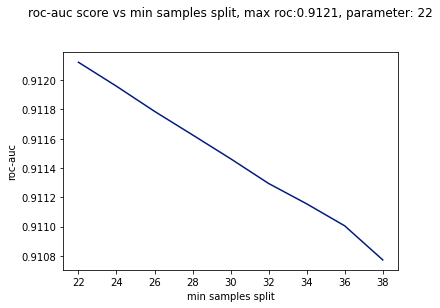

In [101]:
roc_vs(roc_scores,min_samples_split,"min samples split")

#### 4. Min samples per leaf

In [104]:
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5,10,20,30]
roc_scores = []

for m in min_samples_leaf:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 22
        , min_samples_split = 22
        , min_samples_leaf=m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 4b. Visualization
1 sample per leaf at a minimum is an optimal parameter.

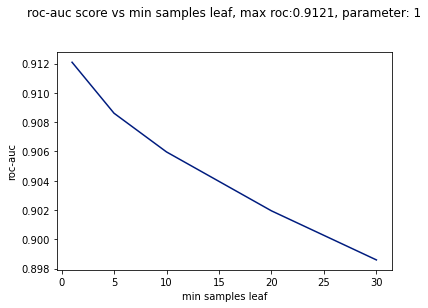

In [105]:
roc_vs(roc_scores,min_samples_leaf,"min samples leaf")

#### 5. criterion for splitting

In [106]:
# Minimum number of samples required at each leaf node
criteria = ["gini","entropy","log_loss"]
roc_scores = []

for c in criteria:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 22
        , min_samples_split = 22
        , min_samples_leaf=1
        , criterion = c 
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 5b. Visualization
In conclusion, any criterion except gini is sufficient for optimization.

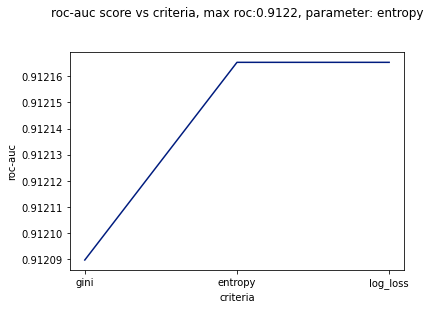

In [107]:
roc_vs(roc_scores,criteria,"criteria")

### Neural Network

In [18]:
neuralNet = MLPClassifier(
    random_state=1
)
neuralNet.fit(train_X_res, train_y_res)

MLPClassifier(random_state=1)

In [19]:
neuralNet_pred = neuralNet.predict(test_X)
classificationSummary(test_y, neuralNet_pred )
evalMetrics(neuralNet,neuralNet_pred)

Confusion Matrix (Accuracy 0.7857)

       Prediction
Actual     0     1
     0 30959  6670
     1  9457 28172
Precision: 0.808564
Recall: 0.748678
F1 score: 0.777470
ROC AUC: 0.881653


{'precision': 0.808564376327421,
 'recall': 0.7486778814212443,
 'f1': 0.7774696085330685,
 'roc_auc': 0.8816531365786706}

Our neural network has an roc-auc of 84%, which is very similar to our random forest model. Here, we can take some steps to optimize our neural network by changing the number of hidden layers, the number of units, the learning rate, and more.

#### 1. Hidden Layer Units

In [24]:
sizes = [150,185,200,215,225]
roc_scores = []

for size in sizes:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(size),
        random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 1b. Visualization
Having 185 nodes in our hidden layer creates the best performance.

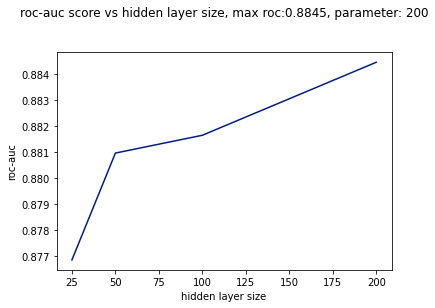

In [25]:
# plot
roc_vs(roc_scores,sizes,"hidden layer size")

#### 2. Number of Iterations

100 iterations is ideal for optimizing our roc-auc scores.
The code for this section has been discarded on account of the fact that, under no circumstances, did modifying the number of max iterations create any chance in performance.

#### 3. Alpha Selection 
**Context**: In this model, the Alpha is the strength of the L2 regularization, which removes a small portion of the weights without ever going down to zero.

In [31]:
alphas =  [0.00005,0.000075,0.0001,0.0002]
roc_scores = []

for alpha in alphas:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(185)
        , alpha = alpha
        , random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 3b. Visualization

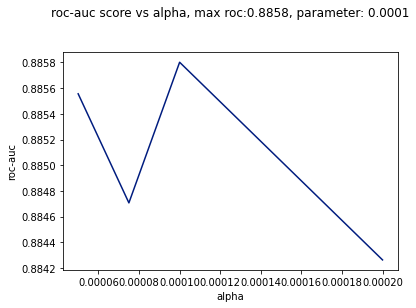

In [32]:
# plot
roc_vs(roc_scores,alphas,'alpha')

#### 4. Adam: Beta-1

In [37]:
beta_ones = [0.95,0.96,0.97]
roc_scores = []

for b in beta_ones:
    
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(185)
        , alpha = 0.0001
        , random_state=1
        , beta_1 = b 
    )
    
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 4b. Visualization

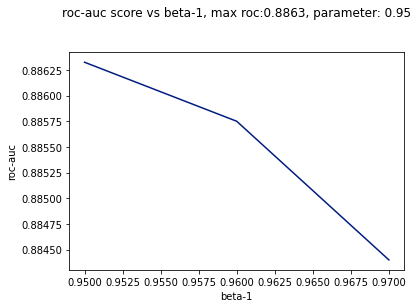

In [38]:
# plot
roc_vs(roc_scores,beta_ones,'beta-1')

#### 5. Activation Function

In [41]:
acs = ['identity','logistic','tanh','relu']
roc_scores = []

for ac in acs:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(185)
        , activation=ac
        , alpha = 0.0001
        , beta_1 = 0.95
        , random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 5b. Visualization

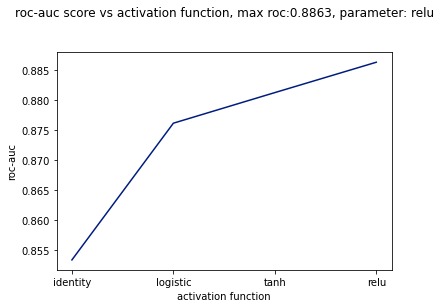

In [42]:
roc_vs(roc_scores,acs,'activation function')

#### 6. Epsilon

In [47]:
epsilons = [float(x) for x in np.linspace(1e-9,1e-7, num = 3)] 
roc_scores = []
for e in epsilons:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(185)
        , activation='relu' 
        , alpha = 0.0001
        , beta_1 = 0.95
        , random_state=1
        , epsilon = e 
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 6b. Visualization

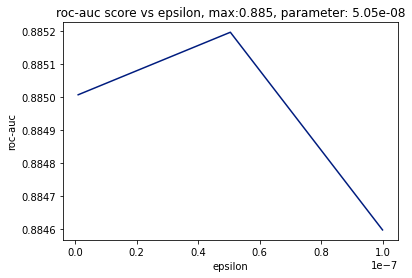

In [48]:
# plot - we dont use the roc_vs wrapper because of how small the values are 
plt.plot(epsilons,roc_scores)
max_roc = max(roc_scores)
max_index = roc_scores.index(max_roc)
max_param = epsilons[max_index]
max_roc = round(max_roc,3)
plt.title(f'roc-auc score vs epsilon, max:{max_roc}, parameter: {max_param}')
plt.ylabel('roc-auc')
plt.xlabel('epsilon')
plt.show()

### Final Models Based on Tuning Results

#### Logistic Regression

In [49]:
lr= LogisticRegression(C=0.125, l1_ratio=0.3, random_state=1, solver='saga')
lr.fit(train_X_res,train_y_res)
lr

LogisticRegression(C=0.125, l1_ratio=0.3, random_state=1, solver='saga')

In [50]:
logit_pred = lr.predict(test_X)
lr_probs = lr.predict_proba(test_X)

#### Naive Bayes

In [48]:
gnb = GaussianNB()
gnb.fit(train_X_res,train_y_res)
gnb

GaussianNB()

In [55]:
gnb_pred = gnb.predict(test_X)
gnb_probs = gnb.predict_proba(test_X)

#### Random Forest

In [57]:
rf = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 22
        , min_samples_split = 22
        , min_samples_leaf=1
        , criterion = 'gini' 
    )
rf.fit(train_X_res,train_y_res)
rf

RandomForestClassifier(max_depth=22, min_samples_split=22, n_estimators=200,
                       random_state=1)

In [58]:
RandomForest_pred = rf.predict(test_X)
rf_probs = rf.predict_proba(test_X)

#### Neural Network

In [59]:
neuralNet = MLPClassifier(
        hidden_layer_sizes=(185)
        , activation='relu' 
        , alpha = 0.0001
        , beta_1 = 0.95
        , random_state=1
        , epsilon = 5e-8
    )
neuralNet.fit(train_X_res,train_y_res)
neuralNet

MLPClassifier(beta_1=0.95, epsilon=5e-08, hidden_layer_sizes=185,
              random_state=1)

In [60]:
neuralNet_pred = neuralNet.predict(test_X)
nn_probs = neuralNet.predict_proba(test_X)

In [61]:
table = {'Models':["Logistic Regression", 
                   "Random Forest",
                   "Neural Network",
                   "Naive Bayes"],
         'Accuracy':[accuracy_score(test_y, logit_pred), 
                     accuracy_score(test_y, RandomForest_pred),
                     accuracy_score(test_y, neuralNet_pred),
                     accuracy_score(test_y, gnb_pred)],
         'Precision':[precision_score(test_y, logit_pred),
                      precision_score(test_y, RandomForest_pred),
                      precision_score(test_y, neuralNet_pred), 
                      precision_score(test_y, gnb_pred)
                     ],
         "Recall":[recall_score(test_y, logit_pred),
                   recall_score(test_y, RandomForest_pred),
                   recall_score(test_y,neuralNet_pred),
                   recall_score(test_y,gnb_pred)
                  ],
         "F1_Score":[f1_score(test_y, logit_pred),
                     f1_score(test_y, RandomForest_pred),
                     f1_score(test_y,neuralNet_pred),
                     f1_score(test_y,gnb_pred)
                    ],
         "ROC AUC":[roc_auc_score(test_y, lr_probs[:, 1]),
                    roc_auc_score(test_y, rf_probs[:, 1]),
                    roc_auc_score(test_y,  nn_probs[:, 1]),
                    roc_auc_score(test_y, gnb_probs[:, 1])
                   ]
}
table_report = pd.DataFrame(table)
# print the data
table_report

,Models,Accuracy,Precision,Recall,F1_Score,ROC AUC
0,Logistic Regression,0.766058,0.803388,0.704536,0.750722,0.853323
1,Random Forest,0.816897,0.820181,0.811768,0.815953,0.912090
2,Neural Network,0.789723,0.835860,0.721040,0.774216,0.885097
3,Naive Bayes,0.744506,0.768338,0.700098,0.732633,0.838289


Our team chose to optimize on ROC-AUC score, with parsimony as a major consideration. In this case, we select the Random Forest model for its performance on ROC, its relatively high accuracy and precision, high recall, and F1-Score.

### Plotting ROC Curves

In [69]:
#helper function
def plot_roc_curves(model_pred,model_name):
    fpr, tpr, _ = roc_curve(test_y, model_pred)
    auc = round(roc_auc_score(test_y, model_pred), 4)
    plt.plot(fpr,tpr,label=f"{model_name}, AUC="+str(auc))  

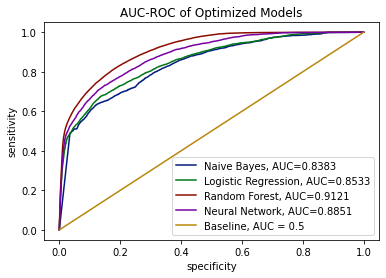

In [83]:
plot_roc_curves(gnb_probs[:,1],'Naive Bayes')
plot_roc_curves(lr_probs[:,1],'Logistic Regression')
plot_roc_curves(rf_probs[:,1],'Random Forest')
plot_roc_curves(nn_probs[:,1],'Neural Network')

x = np.linspace(0,1,1000)
y = x 
plt.plot(x,y,label='Baseline, AUC = 0.5')
plt.xlabel('specificity')
plt.ylabel('sensitivity')
plt.title('AUC-ROC of Optimized Models')
#add legend
plt.legend()

### Export Best Performing Model - Random Forest
We export this model as a pickle file so that we may be able to use it in future ML applications as the team sees fit. Furthermore, this model export is part of a pipeline that goes directly to our streamlit demo, which accesses the repository this notebook is located in to access and load the Random Forest model directly from the pickle.

In [84]:
import pickle
filename = 'model_export/finalized_rf_model.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [85]:
#sanity check - reload form pickle
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

RandomForestClassifier(max_depth=22, min_samples_split=22, n_estimators=200,
                       random_state=1)